In [2]:
#imports 
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline


# FPCA for important regions of flight
## this will be exploratory- find metrics for important timestamps and then apply that knowledge to improve LSTM

In [3]:
#let's run FPCA on X_t and look at the results

import matplotlib.pyplot as plt
import skfda
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)


In [4]:
filename = 'N-CMAPSS_DS02-006.h5'
# Time tracking, Operation time (min):  0.003
t = time.process_time()  

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.033517883333333345

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


In [5]:
#add index columns to help in restructuring
X_c=np.concatenate((A[:,:2],X_s,X_v),axis=1)

In [21]:
#reshape the data. I want individual flights as data points
#what interval of flight to take?
l=[]
for i in np.unique(X_c[:,0]):
    sub=X_c[X_c[:,0]==i]
    for j in np.unique(X_c[:,1]):
        subsub=sub[sub[:,1]==j]
        l.append(len(subsub))

In [22]:
l=np.array(l)

In [23]:
l.shape[0]-np.count_nonzero(l)

153

In [25]:
li=[]
for elem in l:
    if elem==0:
        continue
    else:
        li.append(elem)
li=np.array(li)

In [18]:
l=l[:648]

1006 18169 4172.451259514247 10057.391975308641


Text(0.5, 1.0, 'Flight Lengths')

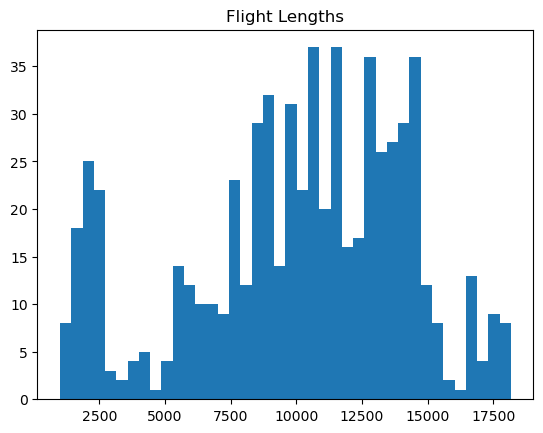

In [27]:
print(np.min(li),np.max(li),np.std(li),np.mean(li))
plt.hist(li,bins=40)
plt.title('Flight Lengths Across all Units')

In [54]:
np.where(l>5000)[0].shape

(560,)

In [36]:
#we should try multiple approaches on account of the variability in flight lengths
#we'll run FPCA on 3 sets of data:
#first 5000, last 5000, middle 5000

In [6]:
#approach 3: sliding window across all flights and units, #kernel samples from each flight
def reshape(arr,kernel,window): #recall this was built with X_c in mind!!
    #data points are sliding windows size w
    #first grab number of flights
    f=0
    for i in np.unique(arr[:,0]):
        dub=arr[arr[:,0]==i] #unit dataset   
        f+=int(np.max(dub[:,1]))



    trim=arr[:,2:] #get rid of indices
    k=trim.shape[1] #only after you've deleted unnecessary features!!!;
    X=np.zeros((560,window,k))
    y=np.zeros((int(kernel*f),))
    t_ticker=0
    from sklearn.preprocessing import MinMaxScaler
    for i,n in enumerate(np.unique(arr[:,0])):
        dub=arr[arr[:,0]==n] #unit
        for j in np.unique(dub[:,1]):
            bub=dub[dub[:,1]==j] #flight
            if bub.shape[0]>5000:
                sub=MinMaxScaler().fit_transform(bub)
                X[i,:window,:]+=sub[:window,2:]

            #sub=dub[dub[:,1]==j]
            #t_tocker=0
            #first 5000
            #X[i,:window,:]+=sub[:window]
            #t_tocker=int(len(sub)//2-kernel//2)

    return X,y

In [54]:
fpca_data,y_fake=reshape(X_c,kernel=100,window=1000)

In [221]:
l=[]
for i in range(560):
    for j in range(28):
        l.append(np.var(fpca_data[i,:,j]))
l=np.array(l)
np.var(l)

In [67]:
f_data=skfda.FDataGrid(data_matrix=fpca_data[:,:,0], grid_points=np.linspace(0,5000,5000).astype(int))

In [68]:
fpca=FPCA(n_components=3)
comps=fpca.fit(f_data)

In [72]:
comps.explained_variance_ratio_ #mean function explains the preponderance of the variation

array([9.99390078e-01, 4.74266933e-04, 8.60764419e-05])

In [104]:
scores=fpca.transform(f_data)

ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 5000, 1)

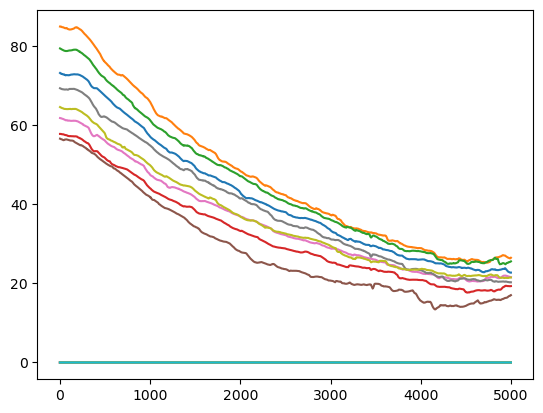

In [129]:
for i in range(30):
    plt.plot(fpca_data[i,:,0])
plt.plot(mean)

In [73]:
#approach 2: middle timestamps

In [33]:
#approach 3: sliding window across all flights and units, #kernel samples from each flight
def reshape(arr,kernel,window): #recall this was built with X_c in mind!!
    #data points are sliding windows size w
    #first grab number of flights
    f=0
    for i in np.unique(arr[:,0]):
        dub=arr[arr[:,0]==i] #unit dataset   
        f+=int(np.max(dub[:,1]))



    trim=arr[:,2:] #get rid of indices
    k=trim.shape[1] #only after you've deleted unnecessary features!!!;
    X=np.zeros((560,window,k))
    y=np.zeros((int(kernel*f),))
    t_ticker=0
    from sklearn.preprocessing import MinMaxScaler
    for i,n in enumerate(np.unique(arr[:,0])):
        dub=arr[arr[:,0]==n] #unit
        for j in np.unique(dub[:,1]):
            bub=dub[dub[:,1]==j] #flight
            if bub.shape[0]>5000:
                sub=MinMaxScaler().fit_transform(bub)
                mini=int(len(sub)//2-window//2)
                maxi=int(len(sub)//2+window//2)
                X[i,:window,:]+=sub[mini:maxi,2:]

            #sub=dub[dub[:,1]==j]
            #t_tocker=0
            #first 5000
            #X[i,:window,:]+=sub[:window]
            #t_tocker=int(len(sub)//2-kernel//2)

    return X,y

In [34]:
fpca_data_2,y_fake=reshape(X_c,kernel=100,window=5000)

In [223]:
l=[]
for i in range(560):
    for j in range(28):
        l.append(np.var(fpca_data_2[i,:,j]))
l=np.array(l)
np.var(l)

202.46996119022347

In [76]:
f_data=skfda.FDataGrid(data_matrix=fpca_data_2[:,:,0], grid_points=np.linspace(0,5000,5000).astype(int))
fpca=FPCA(n_components=3)
comps=fpca.fit(f_data)

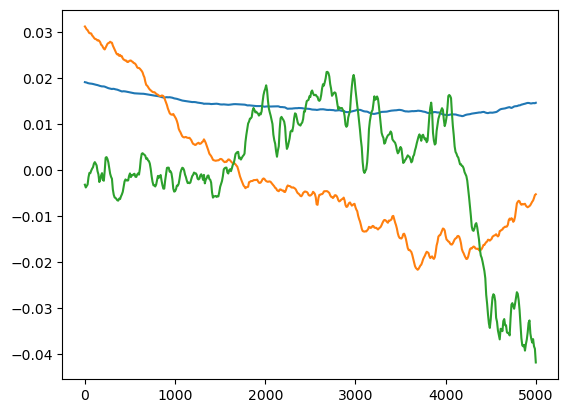

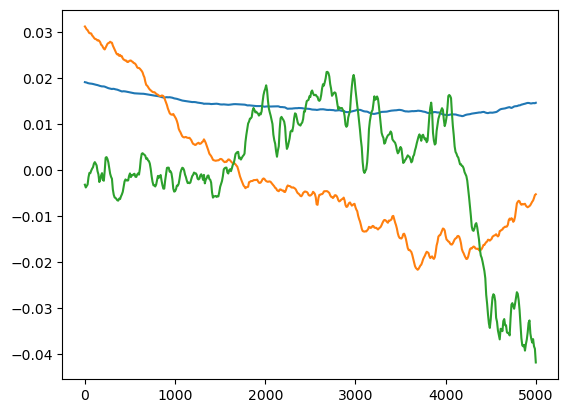

In [77]:
comps.components_.plot()

In [154]:
f_data=skfda.FDataGrid(data_matrix=fpca_data_2[0,:,:].T, grid_points=np.linspace(0,5000,5000).astype(int))
fpca=FPCA(n_components=3)
comps=fpca.fit(f_data)

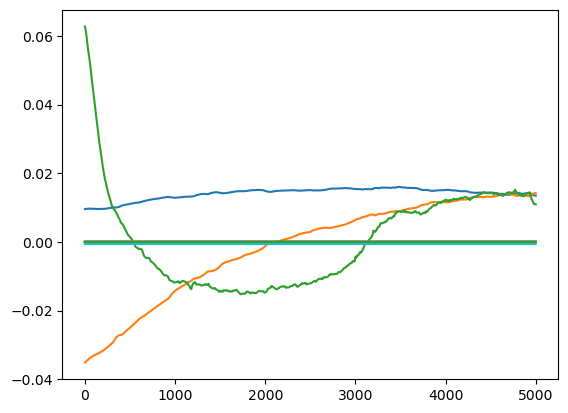

In [29]:
comps.components_.plot()
plt.plot(T[:5000])

In [156]:
comps.explained_variance_ratio_

array([0.80452766, 0.16464899, 0.02676933])

In [79]:
#approach 3: last timestamps

In [188]:
#approach 3: sliding window across all flights and units, #kernel samples from each flight
def reshape(arr,kernel,window): #recall this was built with X_c in mind!!
    #data points are sliding windows size w
    #first grab number of flights
    f=0
    for i in np.unique(arr[:,0]):
        dub=arr[arr[:,0]==i] #unit dataset   
        f+=int(np.max(dub[:,1]))
    trim=arr[:,2:] #get rid of indices
    k=trim.shape[1] #only after you've deleted unnecessary features!!!;
    #X=np.zeros((560,window,k))
    X=[]
    y=np.zeros((int(kernel*f),))
    t_ticker=0
    from sklearn.preprocessing import MinMaxScaler
    for i,n in enumerate(np.unique(arr[:,0])):
        dub=arr[arr[:,0]==n] #unit
        for j in np.unique(dub[:,1]):
            bub=dub[dub[:,1]==j] #flight j of unit i
            if bub.shape[0]>5000:
                sub=MinMaxScaler().fit_transform(bub)
                X.append(sub[-window:,2:])
            else:
                continue

            #sub=dub[dub[:,1]==j]
            #t_tocker=0
            #first 5000
            #X[i,:window,:]+=sub[:window]
            #t_tocker=int(len(sub)//2-kernel//2)

    return np.stack(X),y

In [189]:
fpca_data_3,y_fake=reshape(X_c,kernel=100,window=5000)

In [201]:
import scipy.signal
from scipy.signal import butter, filtfilt


In [203]:
fpca_sm=np.zeros((560,5000,28))
b, a = butter(N=3, Wn=0.5, btype='low')
for i in range(560):
    for j in range(28):
        fpca_sm[i,:,j]+=filtfilt(b,a,fpca_data_3[i,:,j])

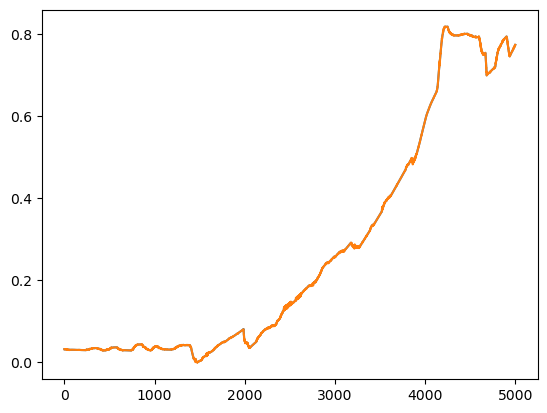

In [209]:
plt.plot(fpca_sm[0,:,10])
plt.plot(fpca_data_3[0,:,10])

In [207]:
f_data=skfda.FDataGrid(data_matrix=fpca_sm[:,:,0].T, grid_points=np.linspace(0,560,560).astype(int))
fpca=FPCA(n_components=3)
comps=fpca.fit(f_data)

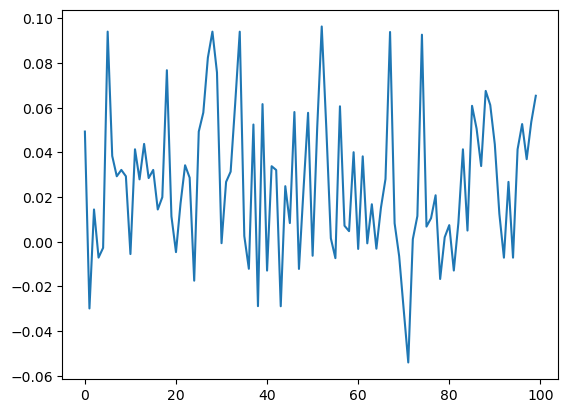

In [211]:
plt.plot(comps.components_.data_matrix[0,:100])

In [194]:
comps.explained_variance_ratio_

array([0.43061095, 0.17775293, 0.08423395, 0.04881741])

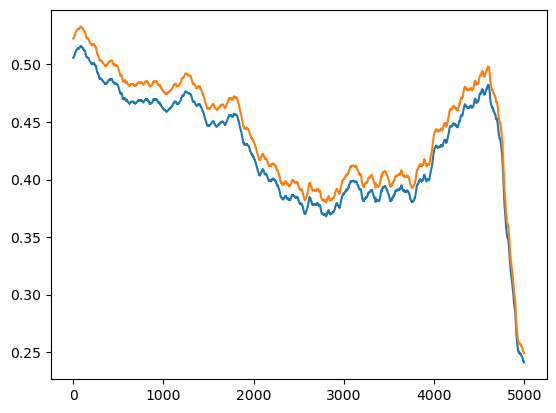

In [120]:
plt.plot(mean[0])
plt.plot(mean[0]+comp1[0])

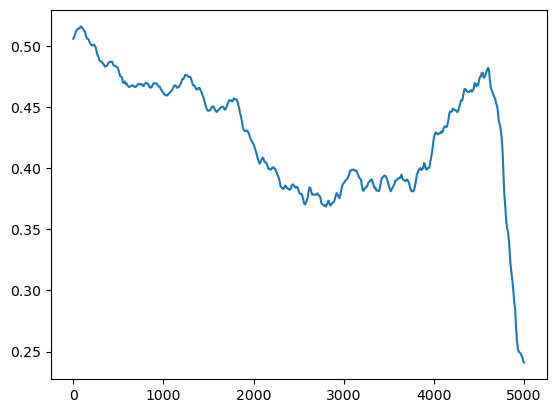

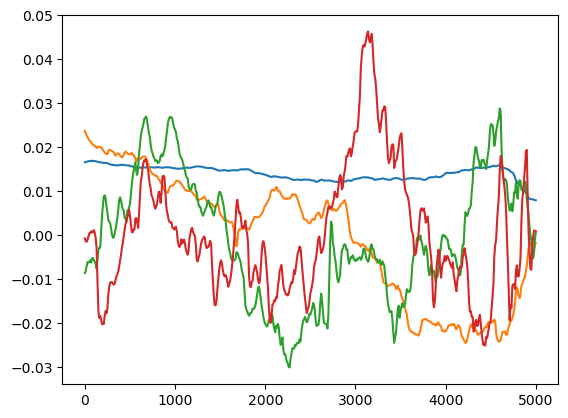

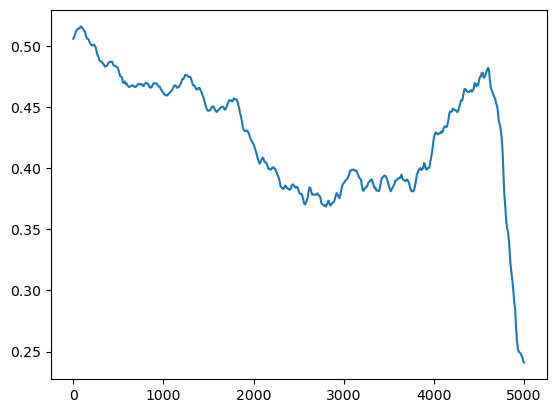

In [100]:
comps.components_.plot()
comps.mean_.plot()

In [101]:
comps.explained_variance_ratio_

array([9.93616479e-01, 5.14442128e-03, 4.51442741e-04, 2.91236902e-04])

In [213]:
#approach 3: sliding window across all flights and units, #kernel samples from each flight
def reshape(arr,kernel,window): #recall this was built with X_c in mind!!
    #data points are sliding windows size w
    #first grab number of flights
    f=0
    for i in np.unique(arr[:,0]):
        dub=arr[arr[:,0]==i] #unit dataset   
        f+=int(np.max(dub[:,1]))
    trim=arr[:,2:] #get rid of indices
    k=trim.shape[1] #only after you've deleted unnecessary features!!!;
    #X=np.zeros((560,window,k))
    X=[]
    y=np.zeros((int(kernel*f),))
    t_ticker=0
    from sklearn.preprocessing import MinMaxScaler
    for i,n in enumerate(np.unique(arr[:,0])):
        dub=arr[arr[:,0]==n] #unit
        for j in np.unique(dub[:,1]):
            bub=dub[dub[:,1]==j] #flight j of unit i
            if bub.shape[0]>5000:
                sub=MinMaxScaler().fit_transform(bub)
                mini=int(len(sub)//2-window//2)
                maxi=int(len(sub)//2+window//2)
                X.append(sub[mini:maxi,2:])
            else:
                continue

            #sub=dub[dub[:,1]==j]
            #t_tocker=0
            #first 5000
            #X[i,:window,:]+=sub[:window]
            #t_tocker=int(len(sub)//2-kernel//2)

    return np.stack(X),y

R2Score(y_test,)

In [214]:
fpca_data_3,y_fake=reshape(X_c,kernel=100,window=5000)

In [215]:
fpca_sm=np.zeros((560,5000,28))
b, a = butter(N=3, Wn=0.5, btype='low')
for i in range(560):
    for j in range(28):
        fpca_sm[i,:,j]+=filtfilt(b,a,fpca_data_3[i,:,j])

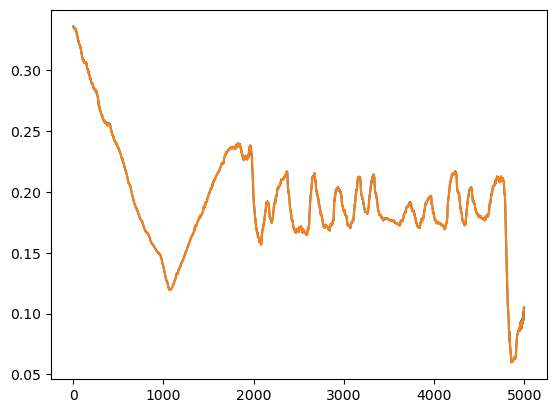

In [217]:
plt.plot(fpca_data_3[0,:,0])
plt.plot(fpca_sm[0,:,0])

In [23]:
f_data=skfda.FDataGrid(data_matrix=fpca_data[0,:,:].T, grid_points=np.linspace(0,5000,5000).astype(int))
fpca=FPCA(n_components=3)
comps=fpca.fit(f_data)

Text(0.5, 1.0, 'PCA k=3 on Average Flight Climbout')

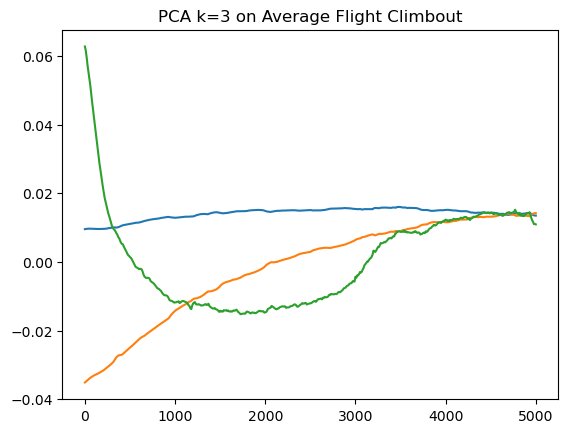

In [24]:
comps.components_.plot()
plt.title('PCA k=3 on Average Flight Climbout')

In [26]:
comps.explained_variance_ratio_

array([0.78824876, 0.21071235, 0.00094848])

In [35]:
#create matrix of 28 mean functions over 5000 timestamps
#study covariance therein
l=np.zeros((5000,28))
for i in range(28):
    for t in range(5000):
        l[t,i]+=(np.mean(fpca_data_2[:,t,i]))

In [234]:
import seaborn as sns

In [46]:
c=np.zeros((24,24))
for i in range(24):
    for j in range(24):
        if c[i,j]==0:
            c[i,j]+=np.corrcoef(l[:,i],l[:,j])[0,1]
        else:
            continue

Text(0.5, 1.0, 'Correlation Heatmap')

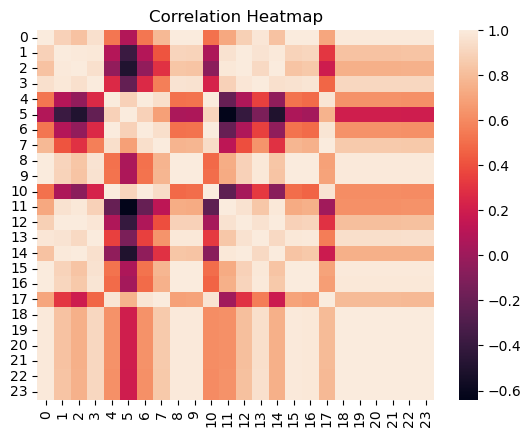

In [49]:
sns.heatmap(c)
plt.title('Correlation Heatmap')

In [41]:
l[:,19].shape

(5000,)

In [42]:
np.count_nonzero(l[:,19])

5000

In [50]:
c=np.zeros((16,16))
for i in range(16):
    for j in range(16):
        if c[i,j]==0:
            c[i,j]+=np.corrcoef(l[:,i],l[:,j])[0,1]
        else:
            continue

<Axes: >

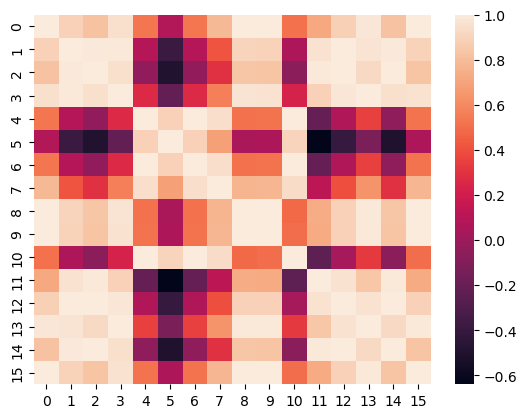

In [51]:
sns.heatmap(c)

In [52]:
from skfda.ml.regression import FPCARegression


In [ ]:
l=[]
for i in np.linspace(10,70,7).astype(int):
    fpca1=FPCARegression(n_components=i)
    fpca1.fit(x_tr,logy_tr[:,0])
    l.append(fpca1.score(x_te,logy_te[:,0]))